# Discogs Track Length Analysis

## Overview
This project pulls 100 albums from each year from 1954 (when modern vinyl was first made commercially available) to 2024 and averages out the 

## Methodology
This notebook queries the [Discogs API](https://www.discogs.com/developers/) through Joalla's [Discogs API Client for Python](https://python3-discogs-client.readthedocs.io/en/latest/index.html). It requests 100 albums of each of Discogs's top 8 genres for each year from 2024 to 2025 and adds them to a pandas dataframe, then averages them out and appends information about the genre, year, and sample size of the averaged data. Last, it uses matplotlib to create a histogram of the collected data and exports it to SVG for further editing in Illustrator, Inkscape, or another vector editing program.

Once the raw averages data was exported to csv, I added a column referring to the era of musical technology associated with the year of the release:
- Vinyl (1954 - 1975)
- 8-track (1976 - 1983)
- Cassette (1984 – 1991)
- CD (1992 – 2003)
- MP3 (2004 - 2013)
- Streaming (2014 - 2024)

I then performed an ANOVA analysis on this data in R. See the discogs.R file in this directory for that code.

## Notebook Setup Notes

On the command line, navigate to the desired directory and create and launch a Python virtual environment:

`python -m venv env-name` <br/> <br/>
`source env-name/bin/activate`

Run the following code to install the necessary libraries in your virtual environment:

`pip install time numpy pandas discogs-client ratelimit matplotlib`


In [ ]:
# import libraries
import time
import numpy as np
import pandas as pd
import discogs_client
from ratelimit import limits, sleep_and_retry
import matplotlib.pyplot as plt

## Loop notes

You must authenticate with Discogs before making search requests. See [the Discogs Client documentation](https://python3-discogs-client.readthedocs.io/en/latest/authentication.html) for instructions on how to do OAuth authentication (the user token will not work for this exercise).

Note that the main loop below took about 16 hours to run in full due to rate-limiting, and still returned no results for some years. The sleep and retry decorator did not work as intended to get the loop to rerun a year if it happens to get a 429 rate limiting error from `discogs_client`.

In [ ]:
d = discogs_client.Client('vallport-track-time-analysis/1.0', 
                          consumer_key='SazbMDUQVopkECPxOBLo',
                          consumer_secret='mrRbIxeefqWYxTLcTrcaRpwPuopbzNOW',
                          token='IziQbytXHUTbUnOViagmMTLiBZSSnhLAqJBIHRFR',
                          secret='vWTnyoAmlKsqWejmFWjOUAuxKRgSgzXoAIpcapSy')

# results lists
columns = ['year', 'duration', 'genre']
genres = ['rock', 'electronic', 'pop', 'folk', 'jazz', 'funk', 'classical', 'hip hop']
data = []
wait = 30
# years 1954 to 2024 (range is non-inclusive)
years = range(1954, 2025)

# convert from mm:ss to seconds
def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# rate limiting function
@sleep_and_retry
@limits(calls=60, period=60)
def safe_fetch(func, *args, **kwargs):
    """Fetch data with rate-limiting."""
    return func(*args, **kwargs)

# main loop
for genre in genres:
    for year in years:
        print(f"Fetching data for genre {genre} in year {year}")
        try:
            # search for master releases from the given year & genre
            search_results = safe_fetch(
                d.search, type='master', year=year, genre=genre, format='album', per_page=100)
            
            # select first page of results
            albums = search_results.page(1)

            for album in albums:
                try:
                    
                    # loop through tracks
                    for track in album.tracklist:

                        duration = track.duration
                        
                        # Convert mm:ss format duration to seconds
                        if duration:
                            duration_seconds = convert_to_seconds(duration)
                        else:
                            duration_seconds = None
                        
                        # Add data to list
                        data.append([year, duration_seconds, genre])
                
                # handle exceptions
                except discogs_client.exceptions.HTTPError as e:
                    if e.status_code == 429:  # rate limit error
                        print(f"Rate limited – waiting {wait} seconds")
                        time.sleep(wait)
                    else:
                        raise        
                except Exception as e:
                    print(f"Fetch error: {e}")
                    continue

                # wait after each request
                time.sleep(1)
        
        except discogs_client.exceptions.HTTPError as e:
            if e.status_code == 429:  # rate limit error
                print(f"Rate limited. Waiting {wait} seconds...")
                time.sleep(wait)
            else:
                continue    
        except Exception as e:
            print(f"Error fetching data for genre {genre} in year {year}: {e}")
            continue

# save as csv
df = pd.DataFrame(data, columns=columns)
df.to_csv('discogs_data_raw.csv', index=False)
print("Saved to 'discogs_data_raw.csv'.")


## Retrieving Individual Years

Use the script below to request results for individual years that either did not pull enough releases with durations, or were skipped entirely due to rate limiting or other errors.

In [ ]:
import discogs_client.exceptions

# import second page for specific genre & year if skipped or too few samples
e_73 = d.search(genre='electronic', year='1973', per_page='100')
e_73_p2 = e_73.page(2)
e_73_t = []
for r in e_73_p2:
    try:
        r_t = r.tracklist
        for index, t in enumerate(r_t):
            try:
                r_t_t = r_t[index]
                duration = convert_to_seconds(str(r_t_t.duration))
                e_73_t.append(duration)
            except ValueError:
                continue
    except discogs_client.exceptions.HTTPError as e:
        print(e)
        continue
    except Exception as e:
        print(e)
        continue
    time.sleep(1)

## Average results

The main loop exports a .csv file of all durations pulled, their genre, and the year of the release (including lines where no duration was available). The next code snippet cleans this raw data of NA duration values and averages all remaining values per genre and year.

In [ ]:
# read in results csv
discdata = pd.read_csv('discogs_data_raw.csv')
years = range(1954, 2025)
genres = ['rock', 'electronic', 'pop', 'folk', 'jazz', 'funk', 'classical', 'hip hop']
columns = ['year', 'genre', 'mean', 'n']
averages = []

# average individual duration data per genre & year
for genre in genres:
    # load duration data for specific genre & year
    temp_genre = discdata[discdata['genre'] == genre]
    for year in years:
        temp_year = temp_genre[temp_genre['year'] == year]
        not_na = temp_year[temp_year['duration'].notna()]
        # get sample size
        n = len(not_na.index)
        try:
            mean = not_na['duration'].mean()
        except:
            print(f'No data for {genre} in {year}')
            mean = 0
        averages.append([year, genre, mean, n])

# output csv of averages
print_frame = pd.DataFrame(averages, columns=columns)
print_frame.to_csv('averages_raw.csv', index=False)

## Plotting

The following code snippet uses [matplotlib](https://matplotlib.org) to create eight wide, squat bar charts – one for each genre – spanning the years 1954 to 2024. These bar charts share an x-axis, but y-axes of different scales. See matplotlib documentation for more details.

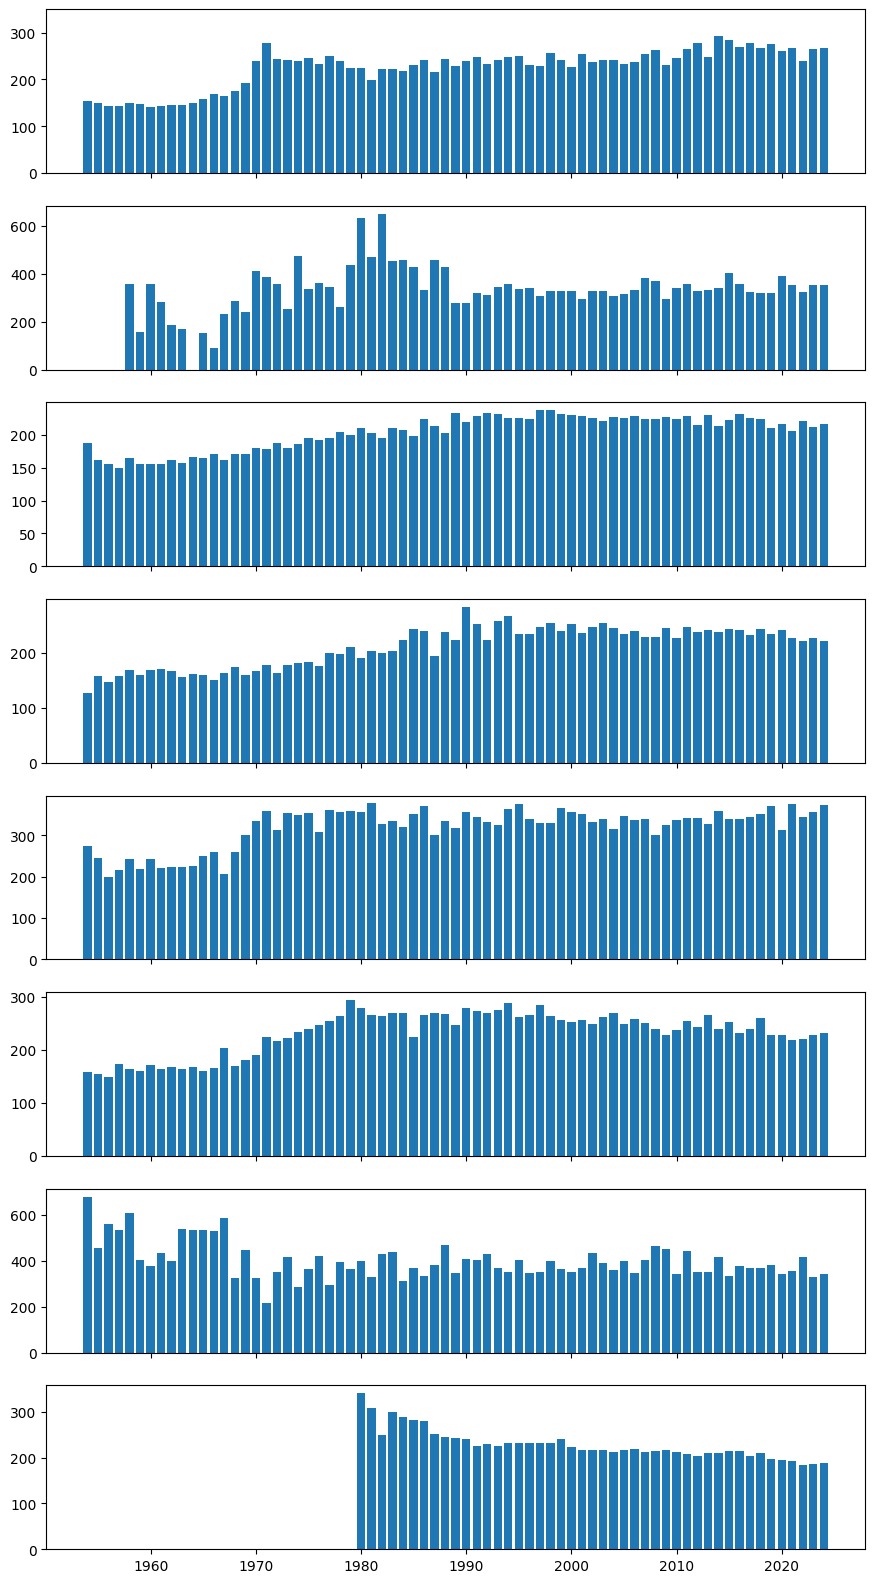

In [ ]:
# plot data across all genres & years in a stack, 7 high 
# adjust figure size
plt.rcParams["figure.figsize"] = [100, 20]
# create 8 plots that share an x-axis
fig, ax = plt.subplots(8, 1, subplot_kw=dict(box_aspect=1/5), sharex=True,)

# read in cleaned average data
avgs = pd.read_csv('averages_raw_edit.csv')

# subset data to plot
rock = avgs[avgs['genre'] == 'rock']
rock_avgs = rock['mean']
pop = avgs[avgs['genre'] == 'pop']
pop_avgs = pop['mean']
jazz = avgs[avgs['genre'] == 'jazz']
jazz_avgs = jazz['mean']
folk = avgs[avgs['genre'] == 'folk']
folk_avgs = folk['mean']
funk = avgs[avgs['genre'] == 'funk']
funk_avgs = funk['mean']
electronic = avgs[avgs['genre'] == 'electronic']
electronic_avgs = electronic['mean']
classical = avgs[avgs['genre'] == 'classical']
classical_avgs = classical['mean']
hiphop = avgs[avgs['genre'] == 'hip hop']
hiphop_avgs = hiphop['mean']
years = np.asarray(range(1954, 2025))

# create bar graphs
ax[0].bar(years, rock_avgs)
ax[1].bar(years, electronic_avgs)
ax[2].bar(years, pop_avgs)
ax[3].bar(years, folk_avgs)
ax[4].bar(years, jazz_avgs)
ax[5].bar(years, funk_avgs)
ax[6].bar(years, classical_avgs)
ax[7].bar(years, hiphop_avgs)

# export to svg
plt.savefig('histograms.svg')